In [2]:
# =============================================================================
# PROJECT 2 (FOREX): MEAN REVERSION - STEP 1 (CORRECTED)
# =============================================================================

import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

# --- Settings ---
# We will analyze the spread between AUD and NZD by looking at the AUD/NZD cross-rate
fx_pair_ticker = 'AUDNZD=X'
start_date = '2015-01-01' # Using a longer history for FX
end_date = '2025-06-27'

# --- Data Download ---
print(f"Downloading data for {fx_pair_ticker}...")

# THE FIX IS HERE: We now use 'Close' instead of 'Adj Close'
prices = yf.download(fx_pair_ticker, start=start_date, end=end_date)['Close'].dropna()

print("Data download complete.")
prices.head()

[*********************100%***********************]  1 of 1 completed

Data download complete.


Ticker,AUDNZD=X
Date,
2015-01-01,1.04673
2015-01-02,1.04910
2015-01-05,1.05240
2015-01-06,1.05120
2015-01-07,1.04306


In [3]:
# --- Stationarity Test (ADF Test) ---
# The null hypothesis of the ADF test is that the series is non-stationary (has a unit root).
# A low p-value (< 0.05) allows us to reject the null hypothesis.

adf_test = sm.tsa.stattools.adfuller(prices)
p_value = adf_test[1]

print(f"ADF Test for {fx_pair_ticker} Price Series:")
print(f"P-value: {p_value:.4f}")

if p_value < 0.05:
    print("Conclusion: The series is likely stationary. A mean-reversion strategy is viable.")
else:
    print("Conclusion: The series is not stationary. This strategy is not suitable.")

ADF Test for AUDNZD=X Price Series:
P-value: 0.0001
Conclusion: The series is likely stationary. A mean-reversion strategy is viable.


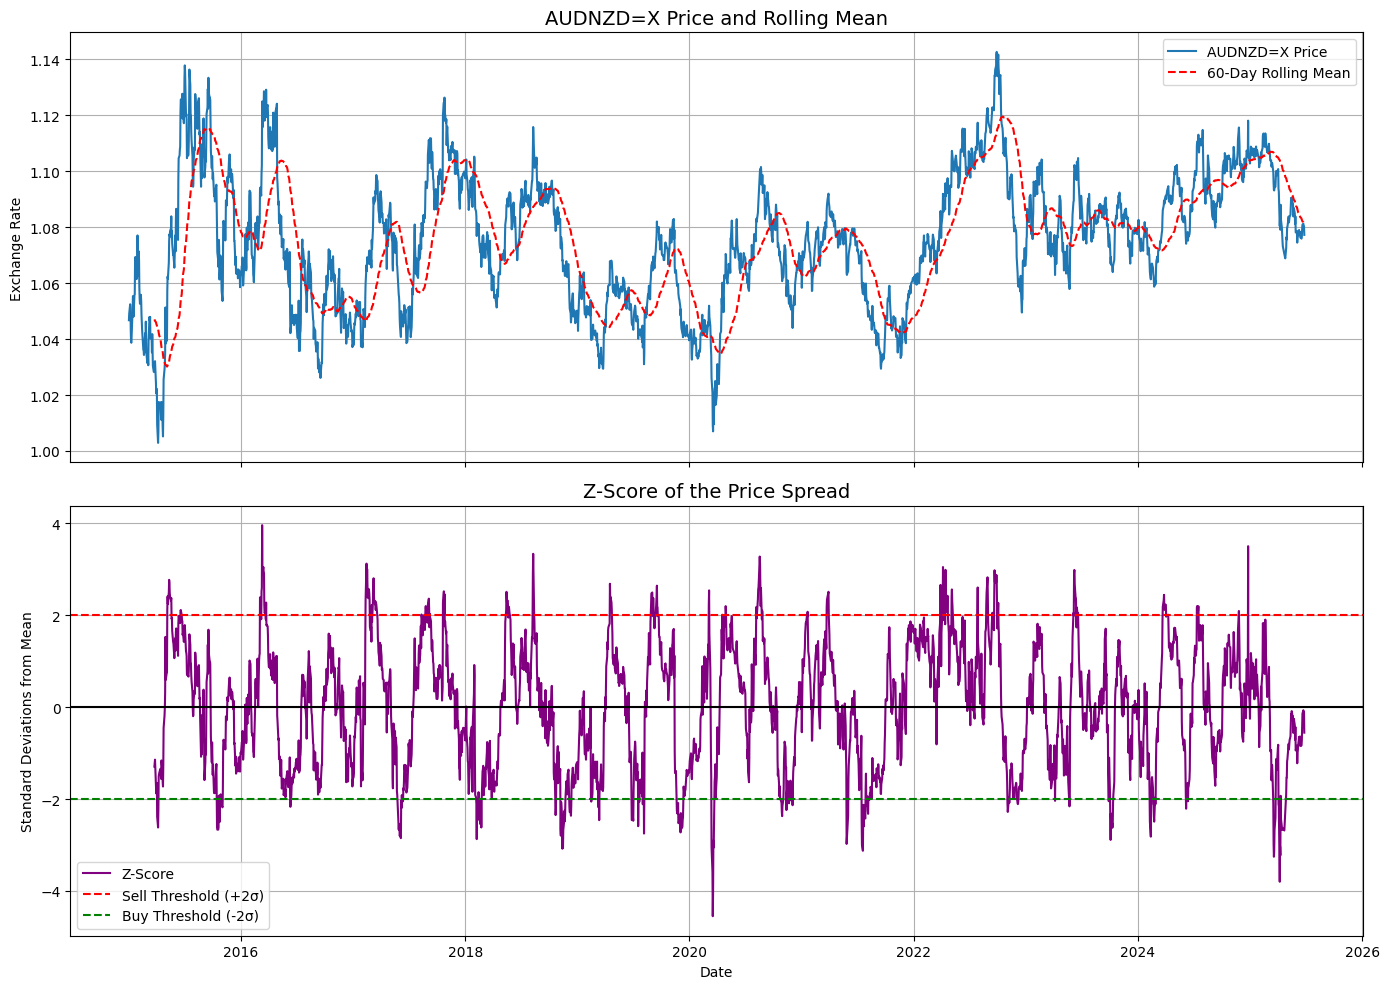

In [4]:
# --- Calculate Z-Score ---
# We calculate the Z-score using a rolling window (e.g., 60 days)
rolling_mean = prices.rolling(window=60).mean()
rolling_std = prices.rolling(window=60).std()

# Calculate the Z-score
z_score = (prices - rolling_mean) / rolling_std

# --- Visualization ---
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Plot 1: Price and Rolling Mean
ax1.plot(prices.index, prices, label=f'{fx_pair_ticker} Price')
ax1.plot(rolling_mean.index, rolling_mean, label='60-Day Rolling Mean', color='red', linestyle='--')
ax1.set_title(f'{fx_pair_ticker} Price and Rolling Mean', fontsize=14)
ax1.set_ylabel('Exchange Rate')
ax1.grid()
ax1.legend()

# Plot 2: Z-Score
ax2.plot(z_score.index, z_score, label='Z-Score', color='purple')
# Add lines for our trading thresholds
ax2.axhline(2.0, color='red', linestyle='--', label='Sell Threshold (+2σ)')
ax2.axhline(-2.0, color='green', linestyle='--', label='Buy Threshold (-2σ)')
ax2.axhline(0.0, color='black', linestyle='-')
ax2.set_title('Z-Score of the Price Spread', fontsize=14)
ax2.set_ylabel('Standard Deviations from Mean')
ax2.set_xlabel('Date')
ax2.grid()
ax2.legend()

plt.tight_layout()
plt.show()

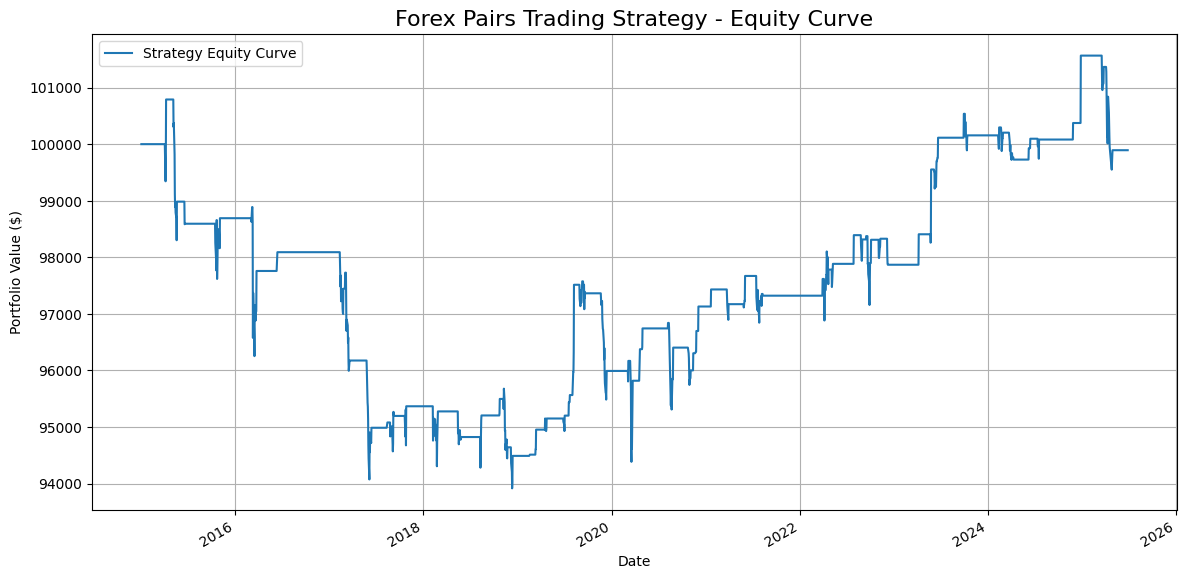


--- Performance ---
Annualized Sharpe Ratio: 0.01
Total Return: -0.11%


In [6]:
# =============================================================================
# PROJECT 2 (FOREX): STEP 4 - TRADING LOGIC AND BACKTEST
# =============================================================================

# Create a new DataFrame for our signals
df = pd.DataFrame(index=prices.index)
df['price'] = prices
df['z_score'] = z_score

# --- Define Trading Signals ---
# -1 = Go Short (Sell the pair)
# +1 = Go Long (Buy the pair)
# 0  = Exit position / Do nothing

df['signal'] = 0 # Start with no signal

# When Z-score > 2, we want to be in a short position (-1)
df.loc[df['z_score'] > 2.0, 'signal'] = -1

# When Z-score < -2, we want to be in a long position (+1)
df.loc[df['z_score'] < -2.0, 'signal'] = 1

# When Z-score crosses 0, we exit the position (signal becomes 0)
# We need to handle this carefully to only exit when we are IN a trade.
# This logic says: if yesterday we were long/short, and today the z-score is back in the middle, exit.
df.loc[((df['signal'].shift(1) == 1) & (df['z_score'] > 0)) |
       ((df['signal'].shift(1) == -1) & (df['z_score'] < 0)), 'signal'] = 0


# --- Create Positions ---
# The 'positions' column represents the position we hold each day.
# .ffill() (forward-fill) holds the last signal until a new one appears.
df['positions'] = df['signal'].ffill().fillna(0)


# --- Calculate Strategy Returns ---
# Calculate the daily returns of the currency pair
df['daily_returns'] = df['price'].pct_change()

# The strategy return is the daily return multiplied by the position held the PREVIOUS day.
df['strategy_returns'] = df['daily_returns'] * df['positions'].shift(1)


# --- Plot the Equity Curve ---
initial_capital = 100000
# Calculate the cumulative returns and the equity curve
cumulative_returns = (1 + df['strategy_returns']).cumprod()
equity_curve = initial_capital * cumulative_returns

plt.figure(figsize=(14, 7))
equity_curve.plot(label='Strategy Equity Curve')
plt.title('Forex Pairs Trading Strategy - Equity Curve', fontsize=16)
plt.ylabel('Portfolio Value ($)')
plt.xlabel('Date')
plt.legend()
plt.grid()
plt.show()

# --- Final Performance Metrics (Corrected) ---
print("\n--- Performance ---")
returns = df['strategy_returns'].dropna()

if not returns.empty and returns.std() != 0:
    sharpe_ratio = np.sqrt(252) * (returns.mean() / returns.std())
    print(f"Annualized Sharpe Ratio: {sharpe_ratio:.2f}")
else:
    print("Sharpe Ratio: N/A")

# FIX: We drop any potential NaN values from the equity curve before getting the final value.
final_equity_curve = equity_curve.dropna()

if not final_equity_curve.empty:
    total_return = (final_equity_curve.iloc[-1] / final_equity_curve.iloc[0]) - 1
    print(f"Total Return: {total_return:.2%}")
else:
    print("Could not calculate Total Return.")